# Understanding KumoRFM Explainability
This notebook is a brief walkthrough of explainability capabilities of the **KumoRFM** model. We will take a look at both `Column Analysis` and `Subgraph` explanations and what we can learn from them.

In [ ]:
!pip install kumoai

In [12]:
import kumoai as kumo
import pandas as pd
import numpy as np

import kumoai.experimental.rfm as rfm
import pandas as pd
import os

from pprint import pprint

In [ ]:
import os

if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()

To illustrate explainability let's use an already familiar dataset - a sampled version of the H&M dataset available on Kaggle (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations). We will load the `users`, `items`, and `orders` and initialize the foundation model - more details can be found in the [quickstart](https://github.com/kumo-ai/kumo-rfm/blob/master/notebooks/quickstart.ipynb) notebook!

In [3]:
root = 's3://kumo-sdk-public/rfm-datasets/ecom'

# load the data
df_dict = {
    'users': pd.read_parquet(f'{root}/users.parquet'),
    'items': pd.read_parquet(f'{root}/items.parquet'),
    'orders': pd.read_parquet(f'{root}/orders.parquet'),
    'returns': pd.read_parquet(f'{root}/returns.parquet'),
}

# local graph
graph = rfm.LocalGraph.from_data(df_dict,  verbose=False)

# initialize the model
model = rfm.KumoRFM(graph, verbose=False)

## Making a prediction
We can make prediction with `KumoRFM.predict(query, ...)`, where `query` is written in PQL (predictive query language). You can find details around the language itself in other notebooks:
* [Predictive Query Tutorial](https://github.com/kumo-ai/kumo-rfm/blob/master/notebooks/predictive_query.ipynb)
* [Predictive Query Internals](https://github.com/kumo-ai/kumo-rfm/blob/master/notebooks/predictive_query_internals.ipynb)

Let's write an example query:

In [4]:
test_query = 'PREDICT COUNT(returns.*, 0, 30, days) > 0 FOR orders.order_id=333'

This query predicts the likelihood of a return happening for order with `order_id=333` in the next 30 days. 

In [5]:
prediction_output = model.predict(test_query)

Output()

The predicton output is a pandas `DataFrame`

In [6]:
type(prediction_output)

pandas.core.frame.DataFrame

and it contains the likelihood for positive/negative outcome given by the model for this particular query. The `ANCHOR_TIMESTAMP` marks the point in time *when* this prediction was made - by default it is the latest fact timestamp in the data.

In [7]:
prediction_output

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,333,2020-09-19,False,0.997071,0.002929


## KumoRFM Explanations
In addition to the likelihoods we can have KumoRFM produce explanations for a particular query! We do this by setting `explain=True`, we can also achieve more granular control through the `ExplainConfig` which we will introduce later.

In [28]:
prediction_output = model.predict(test_query, explain=True)

Output()

We can observe that the output type is different! The output is now an `Explanation`! Irrespective of how `ExplainConfig` is configured the output will be an `Explanation` object and contain both the prediction and the explanation of this prediction.

In [29]:
type(prediction_output)

kumoai.experimental.rfm.rfm.Explanation

we can recover the prediction dataframe by extracting it with `.prediction`

In [30]:
prediction_output.prediction

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED,False_PROB,True_PROB
0,333,2020-09-19,False,0.99708,0.00292


but in addition to the raw prediction scores, the output also includes explanations! By default this explanation is a natural language summary of the factors which lead the model to make a particular prediction. We can obtain this summary with  `Explanation.summary`.

In [33]:
print(prediction_output.summary)

The model predicts that order 333 is very unlikely to have any returns within 30 days, with a predicted return probability of only about 0.3% (True_Prob = 0.0029). This is a strong "no return" prediction (False_PROB = 0.997).

Key factors driving this prediction include:

1. **Order date (score=1.0):** The order date is 2018-09-20, which falls into the oldest cohort of orders by date. Globally, orders in this oldest date cohort have a higher observed return rate (~2%) compared to all other more recent cohorts where return rates are essentially 0%. Despite this, the model weighs this specific order date heavily but in context with other features leads to a low return prediction.

2. **Sales channel ID (score=0.136):** This order's sales channel ID is 2. Globally, sales_channel_id=2 has about a 0.28% return rate, slightly higher than channel 1 (0%). This is a moderate influence increasing predicted return risk.

3. **Order price (score=0.007):** The price is $8.98, which globally corresp

We can clearly see that the order date is the key driver behind the prediction - since the order happened so long ago it is very unlikely that it will be returned! This natural language summary is extracted from the structured outputs produced by the underlying foundation model. We can extract those through `Explanation.details`!


Prediction ouput details contain a lot of information - firstly it contains the `task_type`, in the case of our test query the task is a binary classification. Additionally, details include two types of explanations:
1. Column analysis - `detils.cohorts`
2. Subgraph analysis - `details.subgraphs`

Let's extract them so we can take a closer look!

In [34]:
column_analysis = prediction_output.details.cohorts
subgraph_analysis = prediction_output.details.subgraphs[0]

### Understanding Column Analyses (`cohorts`)
The cohort analysis provides a **global view** of how different column values correlate with prediction outcomes across all in-context examples used by the model.

#### Structure of Cohort Objects
Each Cohorts object contains:
* `table_name`: The table being analyzed (e.g., 'orders', 'users', 'items')
* `column_name`: The specific column or aggregate statistic (e.g., 'age', 'price', 'COUNT(*)')
* `hop`: Distance from the entity table (0 = entity table itself, 1 = directly linked tables, 2 = second-degree neighbors)
* `stype`: Semantic type (`numerical`, `categorical`, `timestamp`, or `None` for aggregates)
* `cohorts`: List of value ranges (for numerical/timestamp) or categories (for categorical)
* `populations`: Proportion of in-context examples falling into each cohort (sums to 1.0)
* `targets`: Average prediction score for examples in each cohort

In [15]:
pprint(column_analysis)

[Cohorts(table_name='orders',
         column_name='COUNT(*)',
         hop=0,
         stype=None,
         cohorts=['[1 - 1+]'],
         populations=[1.0],
         targets=[0.0020000000949949026]),
 Cohorts(table_name='orders',
         column_name='sales_channel_id',
         hop=0,
         stype=categorical,
         cohorts=['2', '1'],
         populations=[0.7089999914169312, 0.29100000858306885],
         targets=[0.0028208745643496513, 0.0]),
 Cohorts(table_name='orders',
         column_name='price',
         hop=0,
         stype=numerical,
         cohorts=['[2.14 - 9.647]',
                  '(9.647 - 13.99]',
                  '(13.99 - 17.33]',
                  '(17.33 - 20.42]',
                  '(20.42 - 24.98]',
                  '(24.98 - 25.68]',
                  '(25.68 - 34.03]',
                  '(34.03 - 36.12]',
                  '(36.12 - 50.73]',
                  '(50.73 - 199.4]'],
         populations=[0.10000000149011612,
                      0.114

#### Interpreting for a Specific Entity
To understand how a particular entity (e.g., a specific user) relates to the global patterns:

1. Locate the entity's values: Identify which cohort(s) the entity falls into for each column
2. Compare to cohort predictions: Check the targets value for that cohort - this shows the average prediction for entities with similar values
3. Assess relative risk: Compare the cohort's target to other cohorts in the same column to understand if this value indicates higher or lower likelihood of the predicted outcome

**Example: For an order placed recently (within 0-2 months, at hop 0):**
* Falls into the `[0 months, 2 months)` cohort for `orders.date`
* Population: 9.8% of orders are in this recency bucket
* Target: 0.020 (2.04% return rate for recent orders)
* Orders placed 2+ months ago have 0% return rate, indicating recency is a strong signal - newer orders have much higher return probability, likely because customers aren't allowed to return old items!

#### Calculating Column Importance
To quantify which columns are most influential in the model's predictions, use a weighted variance approach:
1. **Calculate weighted variance**: For each column's cohort analysis, computes how much the target predictions vary across different value ranges, weighted by how many examples fall into each cohort
2. **Normalizes scores**: Scales all importance scores to a 0-1 range by dividing by the maximum score, making it easy to compare relative importance

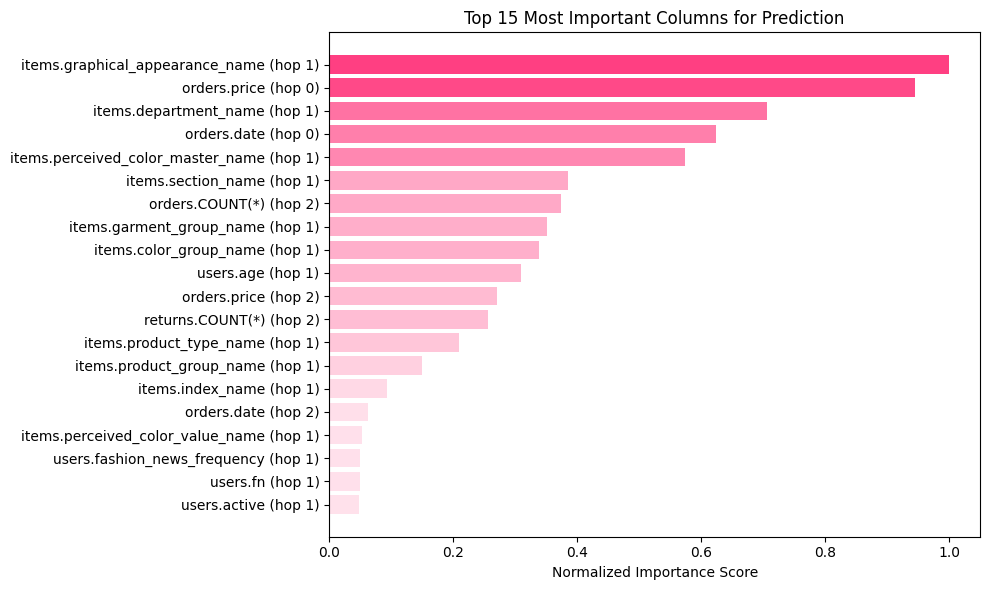

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_column_importance(cohorts_obj):
    """
    Calculate importance score based on variance of targets weighted by populations.
    Higher values indicate the column strongly differentiates predictions.
    """
    populations = np.array(cohorts_obj.populations)
    targets = np.array(cohorts_obj.targets)
    
    # Weighted average of targets
    weighted_mean = np.sum(populations * targets)
    
    # Weighted variance of targets
    weighted_variance = np.sum(populations * (targets - weighted_mean) ** 2)
    
    return weighted_variance

# Calculate importance scores for all columns
importance_scores = []
for cohort in column_analysis:
    score = calculate_column_importance(cohort)
    importance_scores.append({
        'table': cohort.table_name,
        'column': cohort.column_name,
        'hop': cohort.hop,
        'importance': score,
        'label': f"{cohort.table_name}.{cohort.column_name} (hop {cohort.hop})"
    })

# Sort by importance (descending)
importance_scores.sort(key=lambda x: x['importance'], reverse=True)

# Normalize importance scores to [0, 1] range
max_importance = importance_scores[0]['importance']
for item in importance_scores:
    item['normalized_importance'] = item['importance'] / max_importance if max_importance > 0 else 0

# Plot top 15 most important columns
top_n = 20
top_features = importance_scores[:top_n]

plt.figure(figsize=(10, 6))
labels = [item['label'] for item in top_features]
scores = [item['normalized_importance'] for item in top_features]

# Plot each bar individually with its own alpha
bars = plt.barh(range(len(labels)), scores, color='#ff2a74')
for bar, alpha in zip(bars, [0.1 + 0.8 * score for score in scores]):
    bar.set_alpha(alpha)

plt.yticks(range(len(labels)), labels)
plt.xlabel('Normalized Importance Score')
plt.title('Top 15 Most Important Columns for Prediction')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

A quick note on why certain columns appear more than once: 
*Internally (in KumoRFM) the relational data is represented as a heterogeneous graph, and a single prediction is made by sampling a "tree" of data, starting from the entity of interest. In the case of above prediction, this "seed node" is order with `order_id=333`, the columns marked with hop 0 are the ones belonging to this entity. Since `orders.price` belongs to the seed node, it must be treated as a "separate feature" in such global analyses, as it is clearly distinct from the influence of `order.price` at hop 2. These would be orders connected to the seed entity through the `item`, `user` or any other connection, should it exist in the graph!*

### Understanding Subgraph Analyses (`subgraphs`)
The subgraph provides a **local view** of the specific entity being predicted, showing the actual data neighborhood with attribution scores that explain which values influenced the prediction.

#### Structure of Subgraph Objects
A `Subgraph` object contains:
* `seed_id`: The node ID of the entity being predicted (always 0)
* `seed_table`: The table containing the entity (e.g., 'orders')
* `seed_time`: The anchor time for the prediction
* `tables`: Dictionary mapping table names to their nodes

Each `Node` represents a row from a table and contains:
* `cells`: Dictionary of column names to Cell objects with:
    * `value`: The actual data value (can be None if missing)
    * `score`: Attribution score from 0 to 1 (higher = more influential)
* `links`: Dictionary mapping relationship names to sets of connected node IDs

**Important:** Node IDs are internal indices (0 to N), not primary keys. The entity being predicted always has ID 0.

In [17]:
pprint(subgraph_analysis)

Subgraph(seed_id=0,
         seed_table='orders',
         seed_time=datetime.datetime(2020, 9, 19, 0, 0),
         tables={'items': {99: Node(cells={'color_group_name': Cell(value='White',
                                                                    score=0.22922731935977936),
                                           'department_name': Cell(value='Jersey '
                                                                         'Basic',
                                                                   score=0.16021528840065002),
                                           'detail_desc': Cell(value='fitted '
                                                                     'vest top '
                                                                     'in '
                                                                     'stretch '
                                                                     'cotton '
                                                            

Key insights for this particular example:
* **Order date has critical importance (score=1.0)**: This old order (from 2018) is the strongest signal. Orders placed ~2 years ago have very different return patterns than recent orders.
* **Price shows strong influence (score=0.291)**: The low price ($8.98) contributes to the prediction.
* **Sales channel moderately important (score=0.222)**: Channel 2 shows different return behavior.

#### Visualizing the Subgraph
To understand the overall structure and importance of different parts of the subgraph, we can create a network visualization where node size and opacity reflect their importance.

**Calculating Node Importance**
First, we need to aggregate cell-level scores to compute node-level importance:

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def calculate_node_importance(subgraph, method='max'):
    """
    Calculate importance score for each node.
    
    Args:
        subgraph: The Subgraph object
        method: 'max' (highest cell score) or 'mean' (average of all cell scores)
    
    Returns:
        Dictionary mapping (table_name, node_id) to importance score
    """
    importance = {}
    
    for table_name, nodes in subgraph.tables.items():
        for node_id, node in nodes.items():
            if len(node.cells) == 0:
                importance[(table_name, node_id)] = 0.0
            else:
                scores = [cell.score for cell in node.cells.values()]
                if method == 'max':
                    importance[(table_name, node_id)] = max(scores)
                elif method == 'mean':
                    importance[(table_name, node_id)] = sum(scores) / len(scores)
                else:
                    raise ValueError(f"Unknown method: {method}")
    
    return importance

# Calculate importance using max method (most influential cell per node)
node_importance = calculate_node_importance(subgraph_analysis, method='max')

**Building the Network Graph**
Now we'll construct a NetworkX graph with all nodes and edges:

In [19]:
def build_network_graph(subgraph, node_importance):
    """
    Build a NetworkX graph from the subgraph with node importance.
    
    Returns:
        G: NetworkX graph
        pos: Node positions for visualization
        node_labels: Dictionary of node labels
    """
    G = nx.Graph()
    
    # Add all nodes with attributes
    for table_name, nodes in subgraph.tables.items():
        for node_id, node in nodes.items():
            node_key = (table_name, node_id)
            importance = node_importance.get(node_key, 0.0)
            
            # Special label for seed node
            if node_id == 0 and table_name == subgraph.seed_table:
                label = f"SEED\n{table_name}\n(ID: {node_id})"
            else:
                label = f"{table_name}\n(ID: {node_id})"
            
            G.add_node(
                node_key,
                table=table_name,
                node_id=node_id,
                importance=importance,
                label=label
            )
    
    # Add all edges based on links
    for table_name, nodes in subgraph.tables.items():
        for node_id, node in nodes.items():
            source_key = (table_name, node_id)
            
            for link_name, target_ids in node.links.items():
                # Parse link name: "source_fk->target_table"
                target_table = link_name.split('->')[-1]
                
                for target_id in target_ids:
                    target_key = (target_table, target_id)
                    
                    # Only add edge if target node exists
                    if target_key in G.nodes():
                        G.add_edge(source_key, target_key)
    
    return G

# Build the graph
G = build_network_graph(subgraph_analysis, node_importance)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 101 nodes and 100 edges


**Visualizing the Network**
Create an informative visualization with node size/opacity reflecting importance:

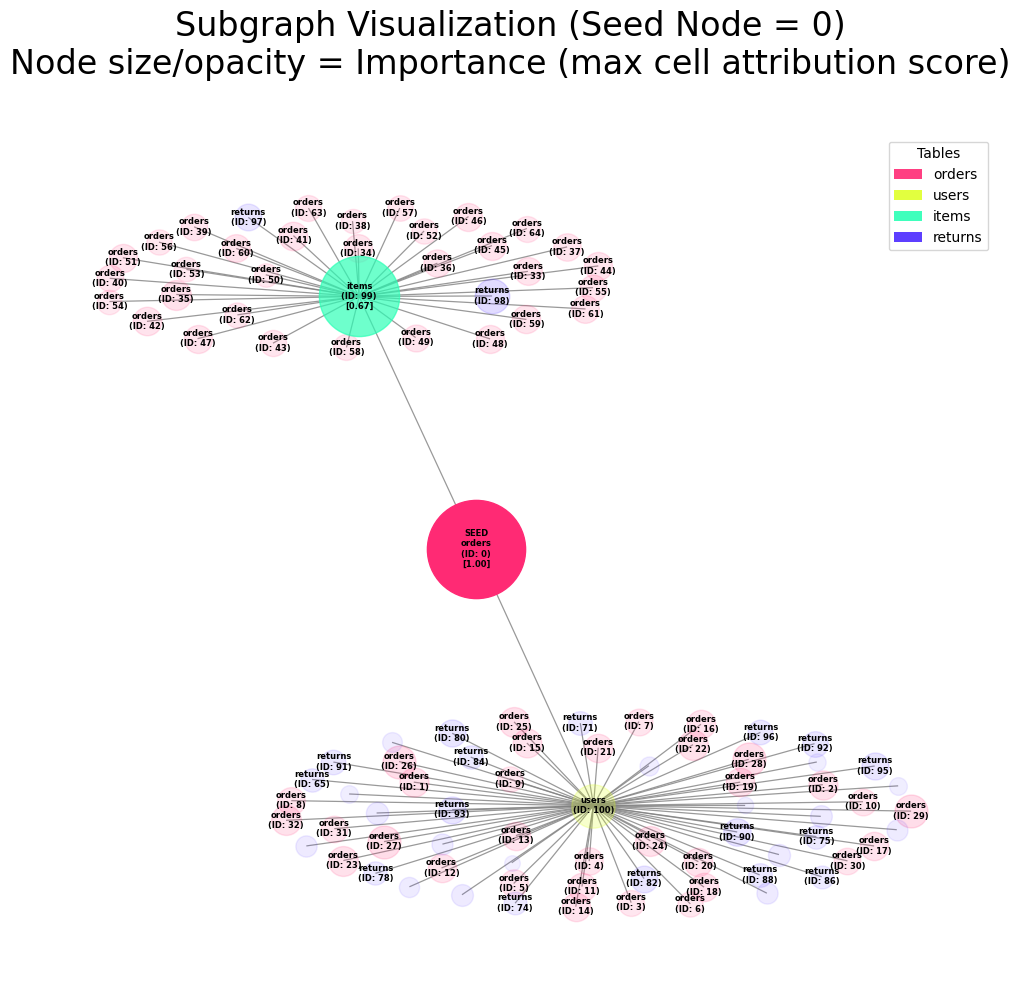

In [20]:
def visualize_subgraph(G, figsize=(10, 10), min_node_size=10, max_node_size=5000):
    """
    Visualize the subgraph with node size/opacity based on importance.
    Uses a BFS layout starting from the seed node to show graph distance.
    
    Args:
        G: NetworkX graph
        figsize: Figure size
        min_node_size: Minimum node size
        max_node_size: Maximum node size
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique tables
    tables_map = nx.get_node_attributes(G, 'table')
    tables = list(set(tables_map.values()))
    
    # Find the seed node (node 0 in seed table)
    seed_node = None
    for node in G.nodes():
        if node[1] == 0:  # node_id == 0
            seed_node = node
            break
    
    # Use BFS layout from seed node
    pos = nx.spring_layout(G, scale=10.0)
    
    # Extract node attributes
    importances = [G.nodes[node]['importance'] for node in G.nodes()]
    labels = nx.get_node_attributes(G, 'label')
    
    # Normalize importance for sizing
    max_importance = max(importances) if importances else 1.0
    normalized_sizes = [
        min_node_size + (imp / max_importance) * (max_node_size - min_node_size)
        for imp in importances
    ]
    
    # Normalize importance for alpha (opacity)
    alphas = [0.05 + 0.95 * (imp / max_importance) for imp in importances]
    
    # Color by table
    table_colors = {
        'orders': '#FF2A74',
        'users': '#DFFF2A',
        'items': '#2AFFB5',
        'returns': '#4B2AFF'
    }
    node_colors = [table_colors.get(tables_map[node], '#CCCCCC') for node in G.nodes()]
    
    # Draw edges first (so they appear behind nodes)
    nx.draw_networkx_edges(
        G, pos, 
        width=0.9, 
        alpha=0.8, 
        edge_color='gray',
        ax=ax
    )
    
    # Draw nodes with varying size and opacity
    for i, node in enumerate(G.nodes()):
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=[node],
            node_size=normalized_sizes[i],
            node_color=[node_colors[i]],
            alpha=alphas[i],
            ax=ax
        )
    
    # Draw labels for high-importance nodes only (to avoid clutter)
    high_importance_threshold = 0.05
    important_labels = {}
    for node in G.nodes():
        importance = G.nodes[node]['importance']
        if importance >= high_importance_threshold:
            label = labels[node]
            # Add score if importance > 0.7
            if importance > 0.2:
                label += f"\n[{importance:.2f}]"
            important_labels[node] = label
    
    nx.draw_networkx_labels(
        G, pos,
        labels=important_labels,
        font_size=6,
        font_weight='bold',
        ax=ax
    )
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=color, label=table, alpha=0.9)
        for table, color in table_colors.items()
        if table in tables
    ]
    ax.legend(handles=legend_elements, loc='upper right', title='Tables')
    
    ax.set_title(
        f'Subgraph Visualization (Seed Node = 0)\n'
        f'Node size/opacity = Importance (max cell attribution score)\n',
        fontsize=24,
        pad=16
    )
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize
visualize_subgraph(G)

### Further configuration of the explanations
We provide more granular control over explainability through the `ExplainConfig` data class. Since summarization of explanations introduces some latency, we provide an option to skip the summary with `skip_summary=True`. In which case only the explanation details are produced.

```{python}
from kumoai.experimental.rfm import ExplainConfig
model.predict(query, explain=ExplainConfig(skip_summary=True))
```

And that's it. Congratulations on reaching this far. Feel free to explore more predictive queries, or read in your own dataset now.

### We'd love to hear from you!


1. **Leave Feedback on `KumoRFM` [here](https://tinyurl.com/rfmbeta)**.

1. **Found a bug or have a feature request?** Submit issues directly on [GitHub](https://github.com/kumo-ai/kumo-rfm). Your feedback helps us improve KumoRFM for everyone.

<div align="left">
  <img src="https://kumo-sdk-public.s3.us-west-2.amazonaws.com/rfm-colabs/kumo_ai_logo.jpeg" width="30" />
</div>